# <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**  
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**  
Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**  
F1-score (sklearn.metrics.f1_score)

**Требования к решению**  
*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Решение должно содержать**  
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

**Рекомендации для файла с кодом (ipynb)**  
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

**Сроки сдачи**  
Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

Ссылка на соревнование - https://www.kaggle.com/c/gb-credit-default/

## <center>Содержание проекта<center>  

1. [Подготовительные работы](#prepare)
2. [Обзор обучающего датасета](#data_review)
3. [Обработка выбросов](#blowout_treatment)
3. [Обработка пропусков](#passes)
4. [Анализ данных](#data_analisys)
5. [Отбор признаков](#feat_choice)
6. [Выбор наилучшей модели, настройка гиперпараметров](#settings)

## <center>Подготовительные работы<a class='anchor' id='prepare'></a><center>

### Подключение библиотек

In [1000]:
import numpy as np
import pandas as pd
import statistics
import pickle
from pathlib import Path

import random

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
import catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns

import featuretools as ft
import featuretools.variable_types as vtypes

from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

### Используемые функции

In [1001]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif c_max == 1 and c_min == 0:
                df[col] = df[col].astype(np.int8)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [1002]:
def reduct_feature(train, test, feat, to_reduct, changing):
    """
    Сокращение значений признака в тренировочной и тестовой выборках.
    
    Возвращает измененные тренировочный и тестовый датафрейма.
    
    train - тренировчный датафрейм
    test - тестовый датафрейм
    feat - признак, который необходимо сократить
    to_change - значения признака, которые необходимо сократить
    changing - значение признака, в которое необходимо преобразовать
    """
    train.loc[train[feat].isin(to_reduct), feat] = changing
    test.loc[test[feat].isin(to_reduct), feat] = changing
    return train, test

In [1003]:
def drop_blowout(train, test, feat, min_q=.025, max_q=.975):  
    """ 
    Избавляет от выбросов в тренировочной и тестовой выборках методом clip.
    
    Возвращает измененные тренировочный и тестовый датафрейма.
    
    train - тренировочная выборка
    test - тестовая выборка
    feat - название признака
    min_q - минимальный квантиль
    min_q - максимальный квантиль
    """
    train[feat] = np.clip(a=train[feat].dropna(),
                          a_min=train[feat].quantile(min_q),
                          a_max=train[feat].quantile(max_q)
    )
    test[feat] = np.clip(a=train[feat].dropna(),
                         a_min=train[feat].quantile(min_q),
                         a_max=train[feat].quantile(max_q)
    )

In [1004]:
def evaluate_linear_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Оценка качества модели по R2 и постройка графиковграфик preds vs true
    
    train_true_values - Целевые значения предсказания выборки train
    train_pred_values - Предсказанные значения выборки train
    test_true_values - Целевые значения предсказания выборки test
    test_pred_values - Предсказанные значения выборки test
    
    """
    
    print('R2_train:\t' + str(round(r2_score(train_true_values, train_pred_values), 3)) + '\n'
          'R2_test:\t' + str(round(r2_score(test_true_values, test_pred_values), 3))
         )
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 8)
    ax1, ax2 = ax.flatten()
    
    ax1.scatter(x=train_pred_values, y=train_true_values)
    ax1.plot([0, train_true_values.max()], [0, train_true_values.max()], color='black')  # целевая диагональ, где true_values = pred_values
    ax1.set_xlim(0, train_true_values.max())
    ax1.set_ylim(0, train_true_values.max())
    ax1.set_xlabel('Predicted values', size=14)
    ax1.set_ylabel('True values', size=14)
    ax1.set_title('Train True vs Predicted values', size=20)
    
    ax2.scatter(x=test_pred_values, y=test_true_values)
    ax2.plot([0, test_true_values.max()], [0, test_true_values.max()], color='black')  # целевая диагональ
    ax2.set_xlim(0, test_true_values.max())
    ax2.set_ylim(0, test_true_values.max())
    ax2.set_xlabel('Predicted values', size=14)
    ax2.set_ylabel('True values', size=14)
    ax2.set_title('Test True vs Predicted values', size=20)

In [1005]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1006]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [1007]:
def generate_ratio_to_income(feats):
    '''
    Функция создаёт новые признаки на тестовой и тренировочной выборках, находя отношения каждого выбранного признака
    к признаку Annual Income
    
    train - тренировочный датасет
    test - тестовый датасет
    feats - список признаков
    '''
    for feat in feats:
        df[f'ratio_{feat}_to_income'] = df[feat] / df['Annual Income']
        df_test[f'ratio_{feat}_to_income'] = df_test[feat] / df_test['Annual Income']

In [1008]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(16,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [1009]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [1010]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Пути к датасетам

In [1011]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'

### Загрузка данных

In [1012]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_test = pd.read_csv(TEST_DATASET_PATH, sep=',')
df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


## <center>Обзор обучающего датасета<a class='anchor' id='data_review'></a><center>

### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1013]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Из краткого резюме видно, что датасет имеет 7500 строк (наблюдений) и 17 столбцов (признаков) (12 вещественных, 1 целочисленный, 4 строковых).  
Остановимся поподробнее на строковых признаках
**Years in current job** - зачем-то указывается не количество лет, а с препиской _'year'_. Необходимо оставить только числа
**Purpose** - цель кредита. Легче всего преобразовать в dummy-переменные. Возможно есть более лаконичный способ (узнаем, когда будем более детально анализировать данные
**Term** - Также легче преобразовать в dummy_переменные, но будет ясно в процессе анализа.

Признаки **Annula Income**, **Months since last delinquent**, **Purpose** и **Credit Score** имеют пропуски в около 15, 55, 0.5, 15 процентах случаев соответственно. Необходимо их заполнить. Возможно пропуски в признаке **Months since last delinquent** означают, что пользователь ни разу не допускал просрочку платежа, поэтому имеется так много пропусков.

In [1014]:
TARGET = 'Credit Default'
BASE_FEAT = df.columns.drop(TARGET).tolist()
OBJ_FEAT = ['Home Ownership', 'Years in current job','Purpose', 'Term']
NUM_FEAT = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [1015]:
df[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Распределение целевой переменной не равномерное, необходимо учитывать этот факт при разбиении выборки на тренировочную и тестовую.

In [1016]:
df[BASE_FEAT + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

Credit Score                    0.442050
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Number of Credit Problems       0.020088
Monthly Debt                    0.018480
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Maximum Open Credit            -0.014275
Current Credit Balance         -0.019522
Years of Credit History        -0.020567
Annual Income                  -0.101375
Current Loan Amount            -0.226522
Name: Credit Default, dtype: float64

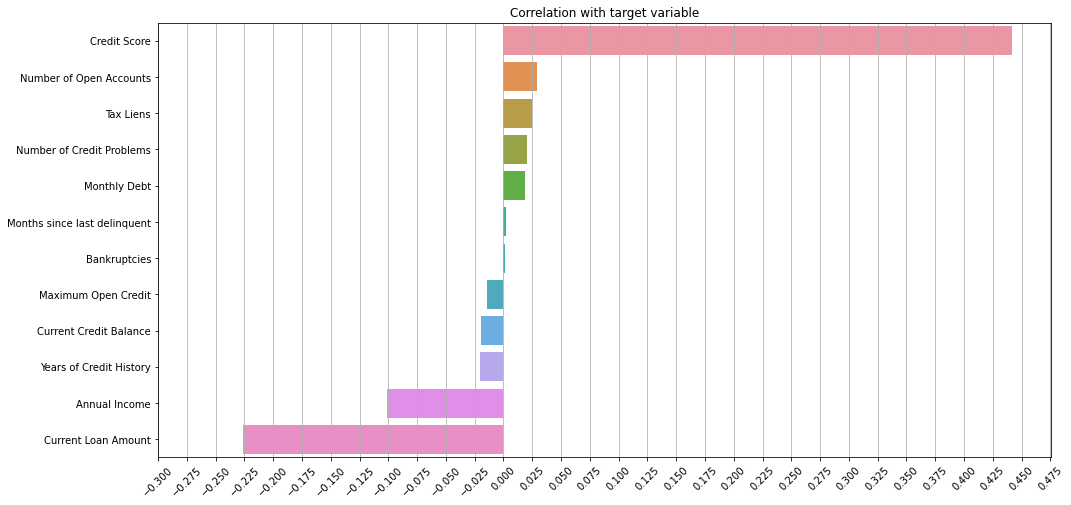

In [1017]:
corr_with_target = df[BASE_FEAT + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(16, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.xticks(np.arange(-0.3, 0.5, step=0.025), rotation=45)
plt.grid(axis='x')
plt.show()

### Распределение вещественных признаков

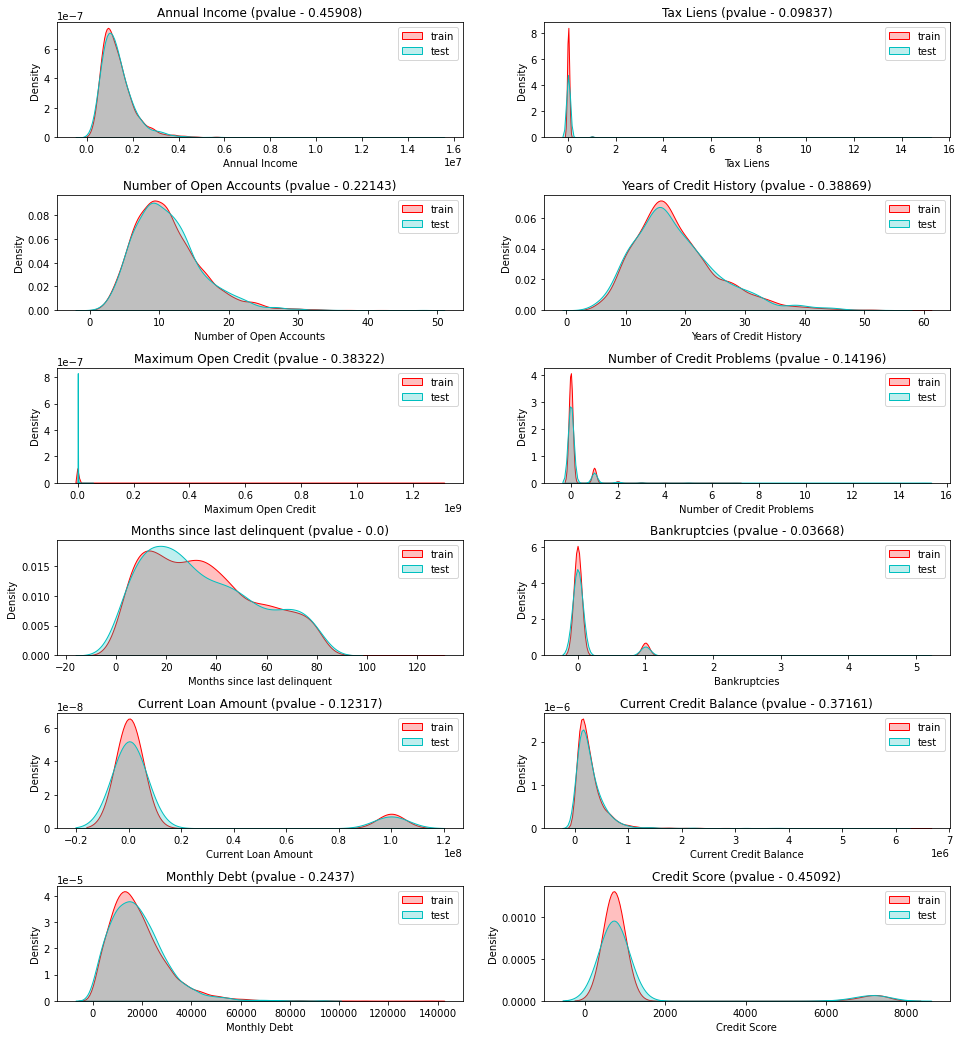

In [1018]:
fig, ax = plt.subplots(ncols=2, nrows=6)
fig.set_size_inches(16, 18)
fig.subplots_adjust(hspace=0.5)

for col in range(len(NUM_FEAT)):
    plt.subplot(ax.flatten()[col])
    sns.kdeplot(df[NUM_FEAT[col]], shade=True, label='train', color='r')
    sns.kdeplot(df_test[NUM_FEAT[col]], shade=True, label='test', color='c')
    plt.legend()
    plt.title(f'{NUM_FEAT[col]} (pvalue - {mannwhitneyu(df[NUM_FEAT[col]], df_test[NUM_FEAT[col]]).pvalue.round(5)})')
plt.show()

Судя по уровню значимости _критерия Манна-Уитни_, вещественные признаки **Months since last delinquent** & **Bankruptсies** не достаточно хорошо совпадают, поэтому, возможно, стоит отбросить их и не использовать в обучении, тем более, что в признаке **Months since last delinquent** пропущено более 50% значений, а признак **Bankruptсies** имеет малое влияние на целевую переменную

In [1019]:
to_del = ['Months since last delinquent', 'Bankruptcies']

### Распределение категориальных признаков

Credit Score


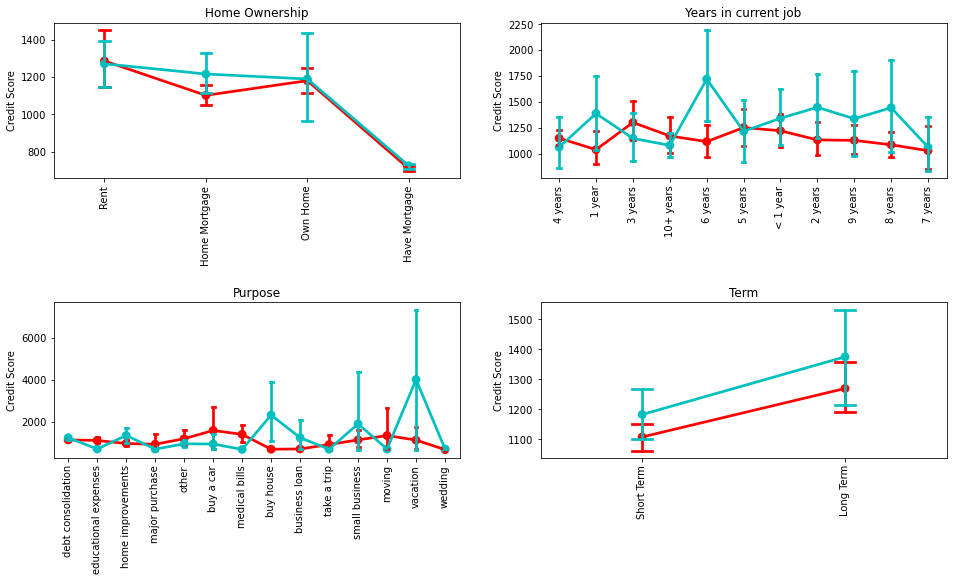

In [1020]:
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(16, 8)
fig.subplots_adjust(hspace=0.8)
num_feature = 'Credit Score'

for col in range(len(OBJ_FEAT)):
    plt.subplot(ax.flatten()[col])
    sns.pointplot(x=OBJ_FEAT[col], y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=OBJ_FEAT[col], y=num_feature, data=df_test, capsize=.1, label='test', color='c')
    plt.title(OBJ_FEAT[col])
    plt.xticks(rotation=90)
    plt.xlabel('')
print(num_feature)
plt.show()

Annual Income


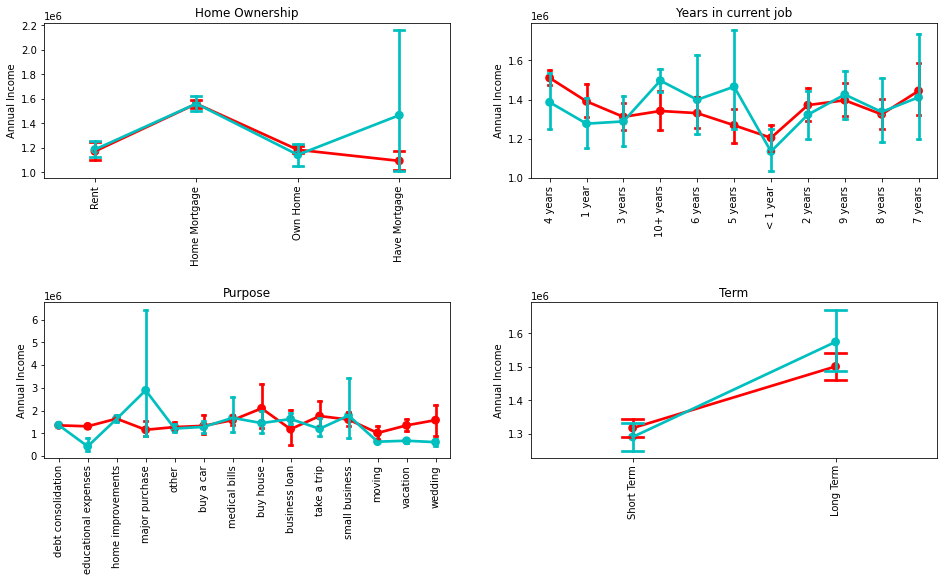

In [1021]:
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(16, 8)
fig.subplots_adjust(hspace=0.8)
num_feature = 'Annual Income'

for col in range(len(OBJ_FEAT)):
    plt.subplot(ax.flatten()[col])
    sns.pointplot(x=OBJ_FEAT[col], y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=OBJ_FEAT[col], y=num_feature, data=df_test, capsize=.1, label='test', color='c')
    plt.title(OBJ_FEAT[col])
    plt.xticks(rotation=90)
    plt.xlabel('')
print(num_feature)
plt.show()

Исходя из полученных графиков, нельзя с уверенностью сказать, что какие-то категиориальные признаки можно смело выбросить, потому что в большинстве своём они имеют схожее математическое ожидание. Сильные отклонения можно списать на выбросы и пропущенные значения.

### Сокращение количество значений в признаке

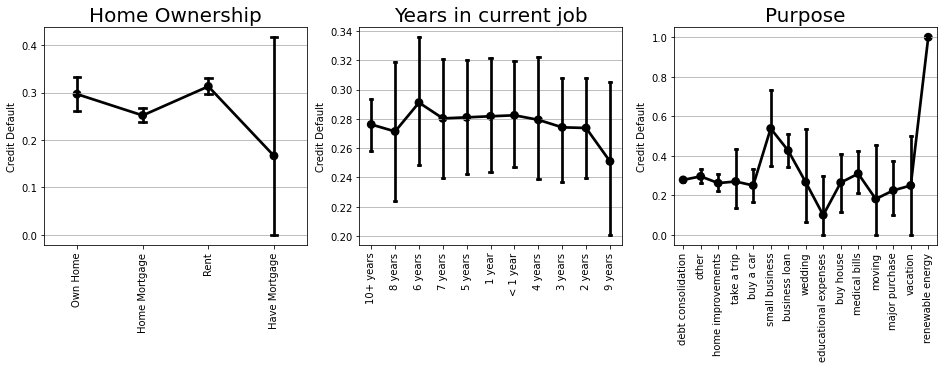

In [1022]:
fig, ax = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(16, 4)
fig.subplots_adjust(wspace=0.2)
feat_to_reduction = ['Home Ownership', 'Years in current job', 'Purpose']

for i, col in enumerate(feat_to_reduction):
    plt.subplot(ax.flatten()[i])
    sns.pointplot(x=col, y=TARGET, data=df, capsize=.1, label='train', color='k')
    plt.title(col, size=20)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.grid(axis='y')
plt.show()

Признак **Home Ownership** можно сократить, объединив значения _Own Home_ и _Rent_.  
Признак **Years in current job** можно сократить, объединив по группам следующие значения:
* _<1 year_ и _1 year_ -> _1 year_ (не объединяем с _5 years_ так как может быть нарушена бизнес-логика)
* _2 years_ и _3 years_ -> 2-3 years (не объединяем с _8 years_ так как может быть нарушена бизнес-логика)
* _4 years_ и _5 years_ -> 4-5 years
Признак **Purpose** можно сократить, объединив по группам следующие значения:
* _debt consolidation_, _other_ и _home improvement_ -> _other_
* _take a trip_, _buy a car_, _buy house_, _medical bills_ и _major purchase_ -> _major purchase_
* _vacation_ и _wedding_ -> _vacation/wedding_

In [1023]:
df, df_test = reduct_feature(df, df_test, feat='Home Ownership', to_reduct=['Own Home', 'Rent'], changing='Own Home/Rent')
df, df_test = reduct_feature(df, df_test, feat='Years in current job', to_reduct=['<1 year', '1 year'], changing='1 year')
df, df_test = reduct_feature(df, df_test, feat='Years in current job', to_reduct=['2 years', '3 years'], changing='2-3 year')
df, df_test = reduct_feature(df, df_test, feat='Years in current job', to_reduct=['4 years', '5 years'], changing='4-5 year')
df, df_test = reduct_feature(df, df_test, feat='Purpose', 
                             to_reduct=['take a trip', 'buy a car', 'buy house', 'medical bills', 'major purchase'], 
                             changing='major purchase')
df, df_test = reduct_feature(df, df_test, feat='Purpose', 
                             to_reduct=['debt consolidation', 'other', 'home improvements'], 
                             changing='other')
df, df_test = reduct_feature(df, df_test, feat='Purpose', 
                             to_reduct=['vacation', 'wedding'], 
                             changing='vacation/wedding')

## <center>Обработка выбросов<a class='anchor' id='blowout_treatment'></a><center>

In [1024]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [1025]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Tax Liens
Признак, имеет неравномерное распределение, так как большинство (от 0 до 75 квантиля) его значений равны нулю, в то время как максимальный элемент выборки равен семи. Проверим его на выбросы, посчитав количество повторений уникальных значений.

In [1026]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [1027]:
df.loc[df['Tax Liens'] >= 6]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1214,Own Home/Rent,3061584.0,2-3 year,6.0,14.0,28.9,949564.0,6.0,67.0,0.0,other,Short Term,99999999.0,352640.0,29595.0,740.0,0
5373,Own Home/Rent,1711881.0,10+ years,6.0,12.0,15.4,551166.0,6.0,26.0,0.0,other,Short Term,313654.0,295602.0,36092.0,741.0,0
5969,Own Home/Rent,2897310.0,10+ years,7.0,9.0,20.0,434126.0,7.0,54.0,0.0,major purchase,Short Term,782782.0,275576.0,37182.0,716.0,0


Скорее всего, все наблюдения с большим процентом налогов просто имеют большую заработную плату, однако странно, что наличие недвижимости не сказывается на налогах.

### Number of Open Accounts

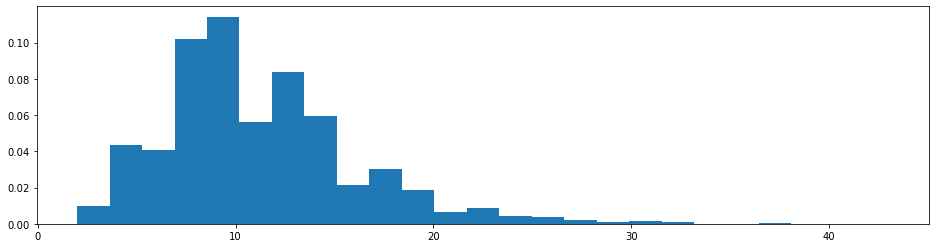

In [1028]:
plt.figure(figsize=(16, 4))
plt.hist(df['Number of Open Accounts'], bins=25, density=True)
plt.show()

Большинство наблюдений имеет не более 10 открытых счетов. Если говорить о данных, применимых в реальной жизни, то не очень понятно, как может быть более 20 счетов, но допустим, что у богатых свои причуды и поднимем планку до 35 (экспертно). Всё что больше - заменим на 35 (также и в тестовой выборке).

In [1029]:
df.loc[df['Number of Open Accounts'] > 35, 'Number of Open Accounts'] = 35
df_test.loc[df_test['Number of Open Accounts'] > 35, 'Number of Open Accounts'] = 35

### Years of Credit History

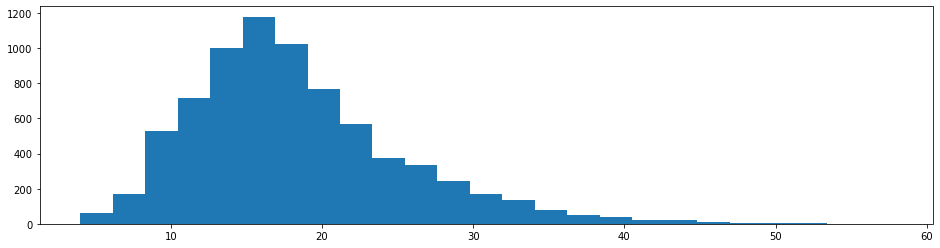

In [1030]:
plt.figure(figsize=(16,4))
plt.hist(df['Years of Credit History'], bins=25)
plt.show()

Судя по всему, в данном признаке явных выбросов нет. Оставим всё как есть

### Maximum Open Credit
Признак явно имеет выбросы, так как максимальное значение сильно удалено от 75 квантиля, а также среднее значение сильно отличается от 50 квантиля

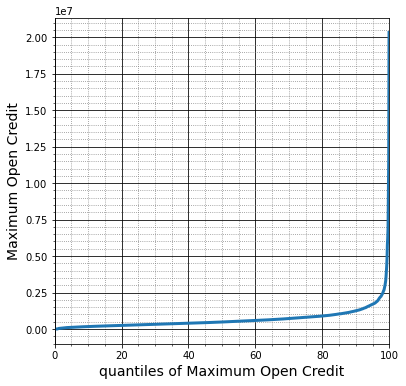

In [1031]:
quantilies = [np.percentile(df['Maximum Open Credit'], q=x) for x in np.arange(0, 100, 0.1)]
plt.figure(figsize=(6,6))

plt.plot(np.arange(0, 100, 0.1), quantilies, linewidth=3)
plt.xlabel("quantiles of Maximum Open Credit", size=14)
plt.ylabel("Maximum Open Credit", size=14)
plt.xlim(0, 100)
plt.minorticks_on()
plt.grid(which='major', color='k')
plt.grid(which='minor', color='grey', linestyle=':')

In [1032]:
drop_blowout(train=df, test=df_test, feat='Maximum Open Credit', min_q=0, max_q=0.995)

### Number of Credit Problems
Также имеется значенительная разница между 75 персентелем и максимальным значением. Узнаем, Зависит ли целевая переменная от данных отклонений.

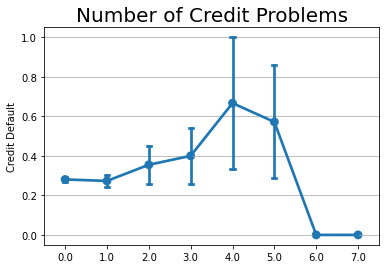

In [1033]:
sns.pointplot(x='Number of Credit Problems', y=TARGET, data=df, capsize=.1, label='train')
plt.title('Number of Credit Problems', size=20)
plt.xlabel('')
plt.grid(axis='y')
plt.show()

Исходя из построенного графика, можно сделать вывод, что эти значения не являются выбросами, а наоборот являются указателями на целевую переменную.

### Current Loan Amount
Имеет очевидные выбросы, так как максимальное значение слишком ровное и удалено от остальных значений.

In [1034]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

Гипотеза подтвердилась, признак имеет выброс со значеним _99 999 999_. Заменим данные значение на случайные числа с распределеним, присущим нашей выборке, однако вместо среднего, использует медиану, так как выброс существенно влияет на среднее значение выборки.

In [1035]:
mask = df['Current Loan Amount'] >= 99999999
df.loc[mask, 'Current Loan Amount'] = random.normalvariate(mu=df['Current Loan Amount'].median(), 
                                                           sigma=df['Current Loan Amount'].std()
)
mask = df_test['Current Loan Amount'] >= 99999999
df_test.loc[mask, 'Current Loan Amount'] = random.normalvariate(mu=df_test['Current Loan Amount'].median(), 
                                                           sigma=df_test['Current Loan Amount'].std()
)

Также проверим признак **Maximum Open Credit**, на значения меньше значений признака **Current Loan Amount**. Если они меньше, заменим на значение признака **Current Loan Amount**.

In [1036]:
mask = df['Current Loan Amount'] > df['Maximum Open Credit']
df.loc[mask, 'Maximum Open Credit'] = df.loc[mask, 'Current Loan Amount']
mask = df_test['Current Loan Amount'] > df_test['Maximum Open Credit']
df_test.loc[mask, 'Maximum Open Credit'] = df_test.loc[mask, 'Current Loan Amount']

### Credit Score
Судя по выборке, признак имеет выбросы, построим график, чтобы в этом убедиться.

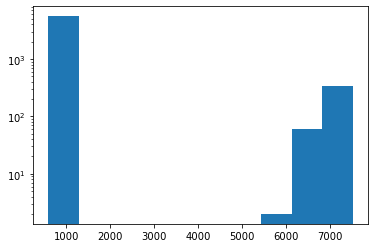

In [1037]:
plt.hist(df['Credit Score'], log=True)
plt.show()

Гипотеза подтверилась. Узнаем природу выбросов.

In [1038]:
df.loc[df['Credit Score'] >= 5000, 'Credit Score'].value_counts()

7400.0    15
7300.0    13
7330.0    13
7170.0    12
7370.0    12
          ..
6830.0     1
6910.0     1
6450.0     1
6610.0     1
6170.0     1
Name: Credit Score, Length: 110, dtype: int64

Судя по всему кредитный рейтинг умножился на _10_. Исправим это.

In [1039]:
df.loc[df['Credit Score'] >= 5000, 'Credit Score'] = df.loc[df['Credit Score'] >= 5000, 'Credit Score'].apply(lambda x: x // 10)
df_test.loc[df_test['Credit Score'] >= 5000, 'Credit Score'] = \
df_test.loc[df_test['Credit Score'] >= 5000, 'Credit Score'].apply(lambda x: x // 10)

## <center>Обработка пропусков<a class='anchor' id='passes'></a><center>

In [1040]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1041]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Annual Income
Количество пропусков - около 20%, присвоим этим данным случайные в схожем распределении значений данного признака

In [1042]:
df.loc[df['Annual Income'].isnull().index, 'Annual Income'] = random.normalvariate(mu=df['Annual Income'].mean(), 
                                                                    sigma=df['Annual Income'].std())
df_test.loc[df_test['Annual Income'].isnull().index, 'Annual Income'] = random.normalvariate(mu=df_test['Annual Income'].mean(), 
                                                                    sigma=df_test['Annual Income'].std())

### Years in current job
Количество пропусков - меньше 10%, присвоим пропускам значение моды

In [1043]:
df['Years in current job'].fillna(statistics.mode(df['Years in current job']), inplace=True)
df_test['Years in current job'].fillna(statistics.mode(df_test['Years in current job']), inplace=True)

### Months since last delinquent
Помним, что схожесть тестовой и тренировочной выборок близка к нулю, но возможно всё дело в имеющихся пропусках. Заполним их и проверим.

In [1044]:
mask = df['Months since last delinquent'].isnull().index
df.loc[mask, 'Annual Income'] = random.normalvariate(mu=df['Months since last delinquent'].mean(), 
                                                     sigma=df['Months since last delinquent'].std())
mask = df_test['Months since last delinquent'].isnull().index
df_test.loc[mask, 'Annual Income'] = random.normalvariate(mu=df_test['Months since last delinquent'].mean(), 
                                                          sigma=df_test['Months since last delinquent'].std())

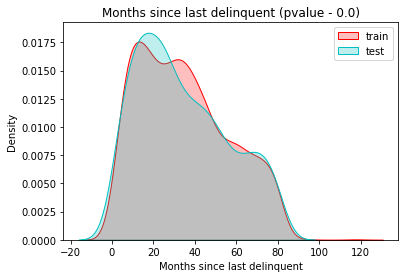

In [1045]:
feat = 'Months since last delinquent'
sns.kdeplot(df[feat], shade=True, label='train', color='r')
sns.kdeplot(df_test[feat], shade=True, label='test', color='c')
plt.legend()
plt.title(f'{feat} (pvalue - {mannwhitneyu(df[feat], df_test[feat]).pvalue.round(5)})')
plt.show()

Гипотеза не подтвердилась. Удаляем признаки

In [1046]:
df.drop(columns=to_del, inplace=True)
df_test.drop(columns=to_del, inplace=True)
for col in to_del:
    BASE_FEAT.remove(col)
    NUM_FEAT.remove(col)

### Credit Score
Заполним пропуски сгрупировав значения признака по другим.

In [1047]:
train_test_concated = pd.concat([df[OBJ_FEAT + ['Credit Score']], df_test[OBJ_FEAT + ['Credit Score']]], axis=0)
train_test_concated = train_test_concated.groupby(OBJ_FEAT, as_index=False).agg(
                      {'Credit Score': 'mean'}).rename(columns={'Credit Score': 'to_merge'})
med = statistics.median(train_test_concated.loc[train_test_concated['to_merge'].notna(), 'to_merge'])
train_test_concated['to_merge'].fillna(med, inplace=True)

In [1048]:
df = pd.merge(left=df, right=train_test_concated, on=OBJ_FEAT, how='left')
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df.loc[df['Credit Score'].isna(), 'to_merge']
df.drop(columns=['to_merge'], inplace=True)
df_test = pd.merge(left=df_test, right=train_test_concated, on=OBJ_FEAT, how='left')
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = df_test.loc[df_test['Credit Score'].isna(), 'to_merge']
df_test.drop(columns=['to_merge'], inplace=True)

In [1049]:
df.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

In [1050]:
df_test.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

Выбросы отработаны, пропуски заполнены. Следует обучить модель, чтобы отслеживать тренд изменения метрики качества.

In [1051]:
X = df[NUM_FEAT]
y = df[TARGET]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [1052]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
evaluate_preds(model_lr, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3631
           1       0.50      0.00      0.00      1394

    accuracy                           0.72      5025
   macro avg       0.61      0.50      0.42      5025
weighted avg       0.66      0.72      0.61      5025

TEST

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1756
           1       0.00      0.00      0.00       719

    accuracy                           0.71      2475
   macro avg       0.35      0.50      0.41      2475
weighted avg       0.50      0.71      0.59      2475

CONFUSION MATRIX

col_0              0  1
Credit Default         
0               1755  1
1                719  0


## <center>Анализ данных<a class='anchor' id='data_analisys'></a><center>

In [1053]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home/Rent,59.005884,10+ years,0.0,11.0,26.3,685960.0,1.0,other,Short Term,-5.354712e+07,47386.0,7914.0,749.0,0
1,Own Home/Rent,59.005884,10+ years,0.0,15.0,15.3,1181730.0,0.0,other,Long Term,2.649680e+05,394972.0,18373.0,737.0,1
2,Home Mortgage,59.005884,8 years,0.0,11.0,35.0,1182434.0,0.0,other,Short Term,-5.354712e+07,308389.0,13651.0,742.0,0
3,Own Home/Rent,59.005884,6 years,0.0,8.0,22.5,147400.0,1.0,other,Short Term,1.213960e+05,95855.0,11338.0,694.0,0
4,Own Home/Rent,59.005884,8 years,0.0,13.0,13.6,385836.0,1.0,other,Short Term,1.258400e+05,93309.0,7180.0,719.0,0


### JobYears
Добавим новый вещественный признак на основе категориального признака **Years in currnet job**

In [1054]:
df['Years in current job'].value_counts()

10+ years    2703
2-3 year     1325
4-5 year      985
< 1 year      563
1 year        504
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1055]:
df['JobYears'] = df['Years in current job']
df_test['JobYears'] = df_test['Years in current job']

In [1056]:
dict_years = {'< 1 year': 0,
             '1 year': 1,
             '2-3 year': 2,
             '4-5 year': 4,
             '6 years': 6,
             '7 years': 7,
             '8 years': 8,
             '9 years': 9,
             '10+ years': 10}
df = df.replace({'JobYears': dict_years})
df_test = df_test.replace({'JobYears': dict_years})

In [1057]:
df = pd.concat([df, pd.get_dummies(df['Years in current job'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Years in current job'])], axis=1)

### Ratio_*_to_Income
Создадим признак, показывающий отношение каждого из признаков **Maximum Open Credit**, **Current Loan Amount**, **Current Credit Balance** к годовому доходу.

In [1058]:
generate_ratio_to_income(['Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance'])

### Ratio Current to Max Loan
Признак показывающий отношение размера последнего кредита к максимальному.

In [1059]:
df['Ratio Current to Max Loan'] = df['Current Loan Amount'] / df['Maximum Open Credit']
df_test['Ratio Current to Max Loan'] = df_test['Current Loan Amount'] / df_test['Maximum Open Credit']

### Ratio Problems to CreditHistory
Признак, показывающий отношение проблем и срока кредитной истории

In [1060]:
df['Ratio Problems to CreditHistory'] = df['Number of Credit Problems'] / df['Years of Credit History']
df_test['Ratio Problems to CreditHistory'] = df_test['Number of Credit Problems'] / df_test['Years of Credit History']

### Ratio Credit Balance to Loan Amount
Признак, показывающий отношение остатка кредита и его изначальной суммы

In [1061]:
df['Ratio Credit Balance to Loan Amount'] = df['Current Credit Balance'] / df['Current Loan Amount']
df_test['Ratio Credit Balance to Loan Amount'] = df_test['Current Credit Balance'] / df_test['Current Loan Amount']

### Loan Term Num
Срок кредита в месяцах

In [1062]:
df['Loan Term Num'] = df['Current Loan Amount'] / df['Monthly Debt']
df_test['Loan Term Num'] = df_test['Current Loan Amount'] / df_test['Monthly Debt']

### Remaining Loan Term
оставшийся срок кредита в месяцах

In [1063]:
df['Remaining Loan Term'] = df['Current Credit Balance'] / df['Monthly Debt']
df_test['Remaining Loan Term'] = df_test['Current Credit Balance'] / df_test['Monthly Debt']
df['Remaining Loan Term'].fillna(9999, inplace=True)
df_test['Remaining Loan Term'].fillna(9999, inplace=True)

### Remaning Loan after Debt
Сумма остатка после погашения в этом месяце

In [1064]:
df['Remaning Loan after Debt'] = df['Current Credit Balance'] - df['Monthly Debt']
df_test['Remaning Loan after Debt'] = df_test['Current Credit Balance'] - df_test['Monthly Debt']

### is Debt Last
Признак, показывающий, является ли погашение в этом месяце последним

In [1065]:
df.loc[df['Remaning Loan after Debt'] <= 0, 'is Debt Last'] = 1
df.loc[df['Remaning Loan after Debt'] > 0, 'is Debt Last'] = 0
df_test.loc[df_test['Remaning Loan after Debt'] <= 0, 'is Debt Last'] = 1
df_test.loc[df_test['Remaning Loan after Debt'] > 0, 'is Debt Last'] = 0

### Term
Вещественный признак в основе признака **Term**

In [1066]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [1067]:
term_dict = {'Short Term': 0, 'Long Term': 1}
df.replace({'Term': term_dict}, inplace=True)
df_test.replace({'Term': term_dict}, inplace=True)

### Target Encode NumProblems
Кодирование целевой переменной через признак **Number of Credit Problems**

In [1068]:
df.groupby('Number of Credit Problems', as_index=False).agg({'Credit Default': 'mean'})

,Number of Credit Problems,Credit Default
0,0.0,0.280569
1,1.0,0.273243
2,2.0,0.354839
3,3.0,0.400000
4,4.0,0.666667
5,5.0,0.571429
6,6.0,0.000000
7,7.0,0.000000


In [1069]:
df_test['Number of Credit Problems'].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

In [1070]:
y_onehot = pd.get_dummies(df['Credit Default'])
temp_df = pd.concat([df, y_onehot], axis=1)
temp_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,...,ratio_Current Credit Balance_to_income,Ratio Current to Max Loan,Ratio Problems to CreditHistory,Ratio Credit Balance to Loan Amount,Loan Term Num,Remaining Loan Term,Remaning Loan after Debt,is Debt Last,0,1
0,Own Home/Rent,59.005884,10+ years,0.0,11.0,26.3,685960.0,1.0,other,0,...,803.072458,-78.061585,0.038023,-0.000885,-6766.126435,5.987617,39472.0,0.0,1,0
1,Own Home/Rent,59.005884,10+ years,0.0,15.0,15.3,1181730.0,0.0,other,1,...,6693.773162,0.224220,0.000000,1.490640,14.421597,21.497415,376599.0,0.0,0,1
2,Home Mortgage,59.005884,8 years,0.0,11.0,35.0,1182434.0,0.0,other,0,...,5226.411015,-45.285508,0.000000,-0.005759,-3922.578903,22.590946,294738.0,0.0,1,0


In [1071]:
for label in y_onehot.columns:    
    temp = temp_df.groupby('Number of Credit Problems', as_index=False).agg({label: 'mean'})
    print(temp)
    temp.columns = ['Number of Credit Problems', f'Problems_Credit Default {label}']
    df = df.merge(temp, on='Number of Credit Problems', how='left')
    df_test = df_test.merge(temp, on='Number of Credit Problems', how='left')
df_test.loc[df_test['Number of Credit Problems']>7, ['Credit Default 0', 'Credit Default 1']] = [0, 1]

   Number of Credit Problems         0
0                        0.0  0.719431
1                        1.0  0.726757
2                        2.0  0.645161
3                        3.0  0.600000
4                        4.0  0.333333
5                        5.0  0.428571
6                        6.0  1.000000
7                        7.0  1.000000
   Number of Credit Problems         1
0                        0.0  0.280569
1                        1.0  0.273243
2                        2.0  0.354839
3                        3.0  0.400000
4                        4.0  0.666667
5                        5.0  0.571429
6                        6.0  0.000000
7                        7.0  0.000000


### Target Encode Purpose
Закодируем целевую переменную через признак **Purpose**. Для начала проверим, возможно ли это.

In [1072]:
df.groupby('Purpose', as_index=False).agg({'Credit Default': 'mean'}).sort_values('Credit Default')

,Purpose,Credit Default
1,educational expenses,0.100000
3,moving,0.181818
7,vacation/wedding,0.260870
2,major purchase,0.266187
4,other,0.279020
0,business loan,0.426357
6,small business,0.538462
5,renewable energy,1.000000


In [1073]:
df_test['Purpose'].value_counts()

other                   2353
major purchase           103
business loan             30
vacation/wedding           5
small business             5
educational expenses       3
moving                     1
Name: Purpose, dtype: int64

Значение целевой переменной для значения _rebewable energy_ в **train** подозрительно высоко и отсутствует в **test**. Примем за выброс и строки с ним.

In [1074]:
# df.drop(index=np.where(df['Purpose'] == 'renewable energy')[0], axis=0, inplace=True)

In [1075]:
y_onehot = pd.get_dummies(df['Credit Default'])
temp_df = pd.concat([df, y_onehot], axis=1)
temp_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,...,Ratio Problems to CreditHistory,Ratio Credit Balance to Loan Amount,Loan Term Num,Remaining Loan Term,Remaning Loan after Debt,is Debt Last,Problems_Credit Default 0,Problems_Credit Default 1,0,1
0,Own Home/Rent,59.005884,10+ years,0.0,11.0,26.3,685960.0,1.0,other,0,...,0.038023,-0.000885,-6766.126435,5.987617,39472.0,0.0,0.726757,0.273243,1,0
1,Own Home/Rent,59.005884,10+ years,0.0,15.0,15.3,1181730.0,0.0,other,1,...,0.000000,1.490640,14.421597,21.497415,376599.0,0.0,0.719431,0.280569,0,1
2,Home Mortgage,59.005884,8 years,0.0,11.0,35.0,1182434.0,0.0,other,0,...,0.000000,-0.005759,-3922.578903,22.590946,294738.0,0.0,0.719431,0.280569,1,0


In [1076]:
for label in y_onehot.columns:    
    temp = temp_df.groupby('Purpose', as_index=False).agg({label: 'mean'})
    print(temp)
    temp.columns = ['Purpose', f'Purpose_Credit Default {label}']
    df = df.merge(temp, on='Purpose', how='left')
    df_test = df_test.merge(temp, on='Purpose', how='left')

                Purpose         0
0         business loan  0.573643
1  educational expenses  0.900000
2        major purchase  0.733813
3                moving  0.818182
4                 other  0.720980
5      renewable energy  0.000000
6        small business  0.461538
7      vacation/wedding  0.739130
                Purpose         1
0         business loan  0.426357
1  educational expenses  0.100000
2        major purchase  0.266187
3                moving  0.181818
4                 other  0.279020
5      renewable energy  1.000000
6        small business  0.538462
7      vacation/wedding  0.260870


### Dummies
Используем метод _get_dummies_ для признаков **Home Ownership** & **Purpose**

In [1077]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'])], axis=1)

In [1078]:
df = pd.concat([df, pd.get_dummies(df['Purpose'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'])], axis=1)

In [1079]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'JobYears', '1 year', '10+ years',
       '2-3 year', '4-5 year', '6 years', '7 years', '8 years', '9 years',
       '< 1 year', 'ratio_Maximum Open Credit_to_income',
       'ratio_Current Loan Amount_to_income',
       'ratio_Current Credit Balance_to_income', 'Ratio Current to Max Loan',
       'Ratio Problems to CreditHistory',
       'Ratio Credit Balance to Loan Amount', 'Loan Term Num',
       'Remaining Loan Term', 'Remaning Loan after Debt', 'is Debt Last',
       'Problems_Credit Default 0', 'Problems_Credit Default 1',
       'Purpose_Credit Default 0', 'Purpose_Credit Default 1', 'Have Mortgage',
       'Home Mortgage', 'Own Home/Rent', 'business lo

In [1080]:
reduce_mem_usage(df)
reduce_mem_usage(df_test)

Memory usage of dataframe is 1.92 MB
Memory usage after optimization is: 0.97 MB
Decreased by 49.6%
Memory usage of dataframe is 0.66 MB
Memory usage after optimization is: 0.33 MB
Decreased by 50.1%


## <center>Отбор признаков<a class='anchor' id='feat_choice'></a><center>

В ячейке ниже закомментированы признаки, которые либо переобучают модель, либо не прибавляют качества прогноза.

In [1081]:
features = [
#             'Home Ownership', 
            'Have Mortgage', 'Home Mortgage', 'Own Home/Rent',
    
            'Annual Income', 
    
            'Years in current job', 
#             '1 year', '10+ years', '2-3 year', '4-5 year', '6 years', '7 years', '8 years', '9 years', '< 1 year',  
#             'JobYears', 
    
            'Tax Liens',
            'Number of Open Accounts', 
            'Years of Credit History',
            'Maximum Open Credit', 
            'Number of Credit Problems', 
    
            'Purpose', 
#             'business loan', 'educational expenses', 'major purchase', 'moving', 'other', 'renewable energy', 
#             'small business', 'vacation/wedding',
    
            'Term',    
            'Current Loan Amount', 
            'Current Credit Balance', 
            'Monthly Debt',
            'Credit Score',
            'ratio_Maximum Open Credit_to_income', 
            'ratio_Current Loan Amount_to_income', 
#             'ratio_Current Credit Balance_to_income',
            'Ratio Current to Max Loan',
            'Remaning Loan after Debt', 
            'is Debt Last',
            'Ratio Problems to CreditHistory',
            'Ratio Credit Balance to Loan Amount', 
            'Remaining Loan Term',
#             'Loan Term Num',
#             'Problems_Credit Default 0', 'Problems_Credit Default 1', 
#             'Purpose_Credit Default 0', 'Purpose_Credit Default 1'
            ]

In [1082]:
NUM_FEAT = ['Have Mortgage', 'Home Mortgage', 'Own Home/Rent', 'Annual Income', 'Tax Liens',
            'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
            'Number of Credit Problems', 'Term', 'Current Loan Amount', 'Current Credit Balance', 
            'Monthly Debt', 'Credit Score', 'ratio_Maximum Open Credit_to_income', 
            'ratio_Current Loan Amount_to_income', 'Ratio Current to Max Loan',
            'Remaning Loan after Debt', 'is Debt Last', 'Ratio Problems to CreditHistory',
            'Ratio Credit Balance to Loan Amount', 'Remaining Loan Term']

In [1083]:
X = df[features]
y = df[TARGET]
CAT_FEATURE_NAMES = ['Have Mortgage', 'Home Mortgage', 'Own Home/Rent', 'Years in current job', 'Purpose']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, stratify=y, random_state=21)
y_train.value_counts()

0    3609
1    1416
Name: Credit Default, dtype: int64

In [1084]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     cat_features=CAT_FEATURE_NAMES,
                                     random_state=21)
model_catb.fit(X_train, y_train)

In [1085]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.99      0.89      3609
           1       0.94      0.43      0.59      1416

    accuracy                           0.83      5025
   macro avg       0.88      0.71      0.74      5025
weighted avg       0.85      0.83      0.81      5025

TEST

              precision    recall  f1-score   support

           0       0.74      0.93      0.83      1778
           1       0.50      0.17      0.25       697

    accuracy                           0.72      2475
   macro avg       0.62      0.55      0.54      2475
weighted avg       0.67      0.72      0.66      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1659  119
1                580  117


Признаки выбраны, но остаётся проблема с переобучением на первом классе. _60_ на **train** против _22_ на **test**. Нулевой класс выглядит адекватно.

## Автоматическая генерация признаков

In [1086]:
es = ft.EntitySet(id='Defaults')
es

Entityset: Defaults
  Entities:
  Relationships:
    No relationships

In [1087]:
df['Id'] = df.index
df_test['Id'] = df_test.index

In [1088]:
features

['Have Mortgage',
 'Home Mortgage',
 'Own Home/Rent',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'ratio_Maximum Open Credit_to_income',
 'ratio_Current Loan Amount_to_income',
 'Ratio Current to Max Loan',
 'Remaning Loan after Debt',
 'is Debt Last',
 'Ratio Problems to CreditHistory',
 'Ratio Credit Balance to Loan Amount',
 'Remaining Loan Term']

In [1089]:
cols = ['Id', 'Have Mortgage', 'Home Mortgage', 'Own Home/Rent', 'Years in current job', 'Purpose']
variable_types = {'Have Mortgage': vtypes.Categorical, 
                  'Home Mortgage': vtypes.Categorical, 
                  'Own Home/Rent': vtypes.Categorical}

es.entity_from_dataframe(entity_id='Credits',
                         dataframe=df[features],
                         index='Id',
                         variable_types=variable_types)

Entityset: Defaults
  Entities:
    Credits [Rows: 7500, Columns: 25]
  Relationships:
    No relationships

In [1090]:
es = es.normalize_entity(base_entity_id='Credits', new_entity_id='Have Mortgage', index='Have Mortgage')
es = es.normalize_entity(base_entity_id='Credits', new_entity_id='Home Mortgage', index='Home Mortgage')
es = es.normalize_entity(base_entity_id='Credits', new_entity_id='Own Home/Rent', index='Own Home/Rent')
es = es.normalize_entity(base_entity_id='Credits', new_entity_id='Years in current job', index='Years in current job')
es = es.normalize_entity(base_entity_id='Credits', new_entity_id='Purpose', index='Purpose')
es

Entityset: Defaults
  Entities:
    Credits [Rows: 7500, Columns: 25]
    Have Mortgage [Rows: 2, Columns: 1]
    Home Mortgage [Rows: 2, Columns: 1]
    Own Home/Rent [Rows: 2, Columns: 1]
    Years in current job [Rows: 9, Columns: 1]
    Purpose [Rows: 8, Columns: 1]
  Relationships:
    Credits.Have Mortgage -> Have Mortgage.Have Mortgage
    Credits.Home Mortgage -> Home Mortgage.Home Mortgage
    Credits.Own Home/Rent -> Own Home/Rent.Own Home/Rent
    Credits.Years in current job -> Years in current job.Years in current job
    Credits.Purpose -> Purpose.Purpose

In [1091]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity='Credits',
                                       verbose=3)

Built 639 features
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [1092]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [1093]:
df_featured = feature_matrix_enc.copy()
df_featured.shape

(7500, 667)

In [1094]:
es_test = ft.EntitySet(id='Credits')

# adding a dataframe 
es_test.entity_from_dataframe(entity_id='Credits', dataframe=df_test[features], index='Id')

es_test = es_test.normalize_entity(base_entity_id='Credits', new_entity_id='Have Mortgage', index='Have Mortgage')
es_test = es_test.normalize_entity(base_entity_id='Credits', new_entity_id='Home Mortgage', index='Home Mortgage')
es_test = es_test.normalize_entity(base_entity_id='Credits', new_entity_id='Own Home/Rent', index='Own Home/Rent')
es_test = es_test.normalize_entity(base_entity_id='Credits', new_entity_id='Years in current job', index='Years in current job')
es_test = es_test.normalize_entity(base_entity_id='Credits', new_entity_id='Purpose', index='Purpose')

In [1095]:
df_test_featured = ft.calculate_feature_matrix(features=features_enc, entityset=es_test)
df_test_featured.head(3)

,Annual Income,Years in current job = 10+ years,Years in current job = 2-3 year,Years in current job = 4-5 year,Years in current job = < 1 year,Years in current job = 1 year,Years in current job = 6 years,Years in current job = 7 years,Years in current job = 8 years,Years in current job = 9 years,...,Purpose.SUM(Credits.Ratio Current to Max Loan),Purpose.SUM(Credits.Ratio Problems to CreditHistory),Purpose.SUM(Credits.Remaining Loan Term),Purpose.SUM(Credits.Remaning Loan after Debt),Purpose.SUM(Credits.Tax Liens),Purpose.SUM(Credits.Term),Purpose.SUM(Credits.Years of Credit History),Purpose.SUM(Credits.is Debt Last),Purpose.SUM(Credits.ratio_Current Loan Amount_to_income),Purpose.SUM(Credits.ratio_Maximum Open Credit_to_income)
Id,,,,,,,,,,,,,,,,,,,,,
0,82.21138,False,False,True,False,False,False,False,False,False,...,-inf,21.98658,42029.000000,663450816.0,81.0,613.0,43211.398438,53,-1.251978e+07,2.092759e+07
1,82.21138,False,False,False,False,True,False,False,False,False,...,0.24002,0.00000,49.420597,121113.0,0.0,0.0,59.599998,0,2.962631e+03,3.675846e+04
2,82.21138,False,True,False,False,False,False,False,False,False,...,-inf,21.98658,42029.000000,663450816.0,81.0,613.0,43211.398438,53,-1.251978e+07,2.092759e+07


In [1096]:
X = df_featured
df_test = df_test_featured

In [1097]:
X.replace(np.inf, 999999, inplace=True)
X.replace(-np.inf, -999999, inplace=True)
df_test.replace(np.inf, 999999, inplace=True)
df_test.replace(-np.inf, -999999, inplace=True)

In [1098]:
nan_feat = X.isna().sum().reset_index().rename(columns={'index':'feature', 0: 'nans_sum'})

In [1099]:
nan_feat = nan_feat.loc[nan_feat['nans_sum'] > 0, 'feature'].to_list()

In [1100]:
X.fillna(0,inplace=True)
df_test.fillna(0, inplace=True)

new_features = X.columns

In [1101]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, stratify=y, random_state=21)
y_train.value_counts()

0    3609
1    1416
Name: Credit Default, dtype: int64

In [1102]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=21)
model_catb.fit(X_train, y_train)
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3609
           1       0.96      0.51      0.67      1416

    accuracy                           0.86      5025
   macro avg       0.90      0.75      0.79      5025
weighted avg       0.87      0.86      0.84      5025

TEST

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1778
           1       0.48      0.16      0.24       697

    accuracy                           0.71      2475
   macro avg       0.61      0.55      0.53      2475
weighted avg       0.67      0.71      0.66      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1659  119
1                587  110


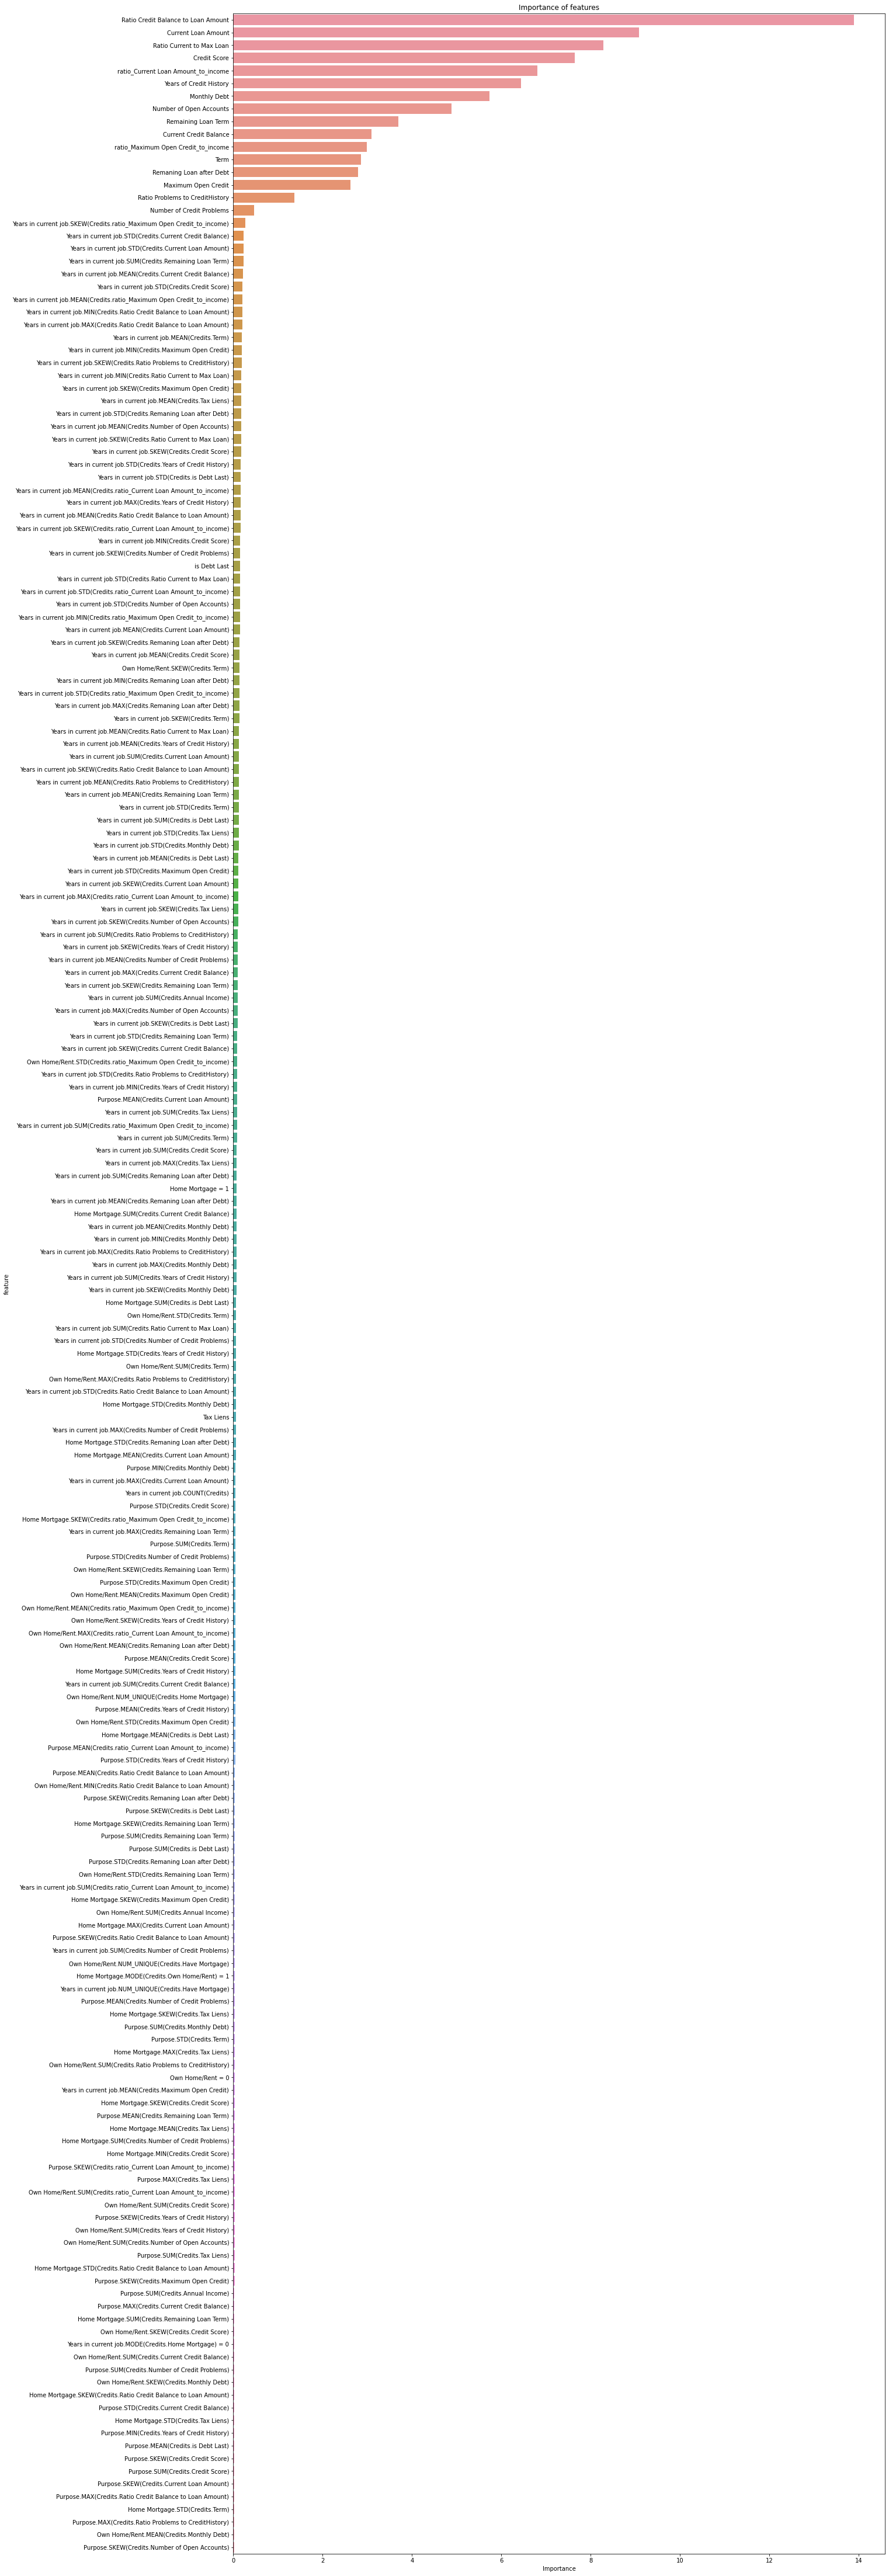

In [1103]:
feature_importances = pd.DataFrame({'feature': new_features,
                                    'importance': model_catb.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)[:200]

plt.figure(figsize = (20, len(feature_importances) * 0.4))

sns.barplot(feature_importances['importance'], feature_importances['feature'])

plt.xlabel('Importance')
plt.title('Importance of features')
plt.show()

In [1104]:
features = feature_importances['feature'].to_list()

### Дисбаланс
Избавимся от дисбаланса классов с помощью штрафов модели. Возможно увеличение качества и уменьшение переобучения.

In [1105]:
disbalance = df[TARGET].value_counts()[0] / df[TARGET].value_counts()[1]
disbalance

2.549455750118315

In [1106]:
df_balanced = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_balanced, TARGET, method='smote')
df_balanced[TARGET].value_counts()

1    3609
0    3609
Name: Credit Default, dtype: int64

In [1107]:
X_train_balanced = df_balanced.drop(columns=TARGET)
y_train_balanced = df_balanced[TARGET]

In [1108]:
scaler = MinMaxScaler()

X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_num_valid_scaled = scaler.transform(X_valid[features])

## <center>Выбор наилучшей модели и настройка гиперпараметров<a class='anchor' id='settings'></a><center>

### LogisticRegression

In [918]:
model_lr = LogisticRegression(C=1, max_iter=7)

model_lr = model_lr.fit(X_train_balanced_scaled, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced_scaled, X_num_valid_scaled, y_train_balanced, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.52      0.58      3609
           1       0.60      0.73      0.66      3609

    accuracy                           0.63      7218
   macro avg       0.63      0.63      0.62      7218
weighted avg       0.63      0.63      0.62      7218

TEST

              precision    recall  f1-score   support

           0       0.83      0.50      0.62      1778
           1       0.37      0.75      0.49       697

    accuracy                           0.57      2475
   macro avg       0.60      0.62      0.56      2475
weighted avg       0.70      0.57      0.59      2475

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               881  897
1               175  522


### SVC

In [919]:
model_svc=SVC(C=0.001, kernel='rbf')

model_svc.fit(X_train_balanced_scaled, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced_scaled, X_num_valid_scaled, y_train_balanced, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      3609
           1       0.60      0.72      0.65      3609

    accuracy                           0.62      7218
   macro avg       0.62      0.62      0.61      7218
weighted avg       0.62      0.62      0.61      7218

TEST

              precision    recall  f1-score   support

           0       0.80      0.49      0.61      1778
           1       0.35      0.69      0.46       697

    accuracy                           0.55      2475
   macro avg       0.57      0.59      0.54      2475
weighted avg       0.67      0.55      0.57      2475

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               880  898
1               219  478


### XGBoost

In [920]:
model_xgb = xgb.XGBClassifier(class_weight=[1, disbalance], random_state=42, objective = "binary:logistic", eval_metric = "logloss",)

model_xgb.fit(X_train[features], y_train)

evaluate_preds(model_xgb, X_train[features], X_valid[features], y_train, y_valid)

[17:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3609
           1       0.99      0.90      0.95      1416

    accuracy                           0.97      5025
   macro avg       0.98      0.95      0.96      5025
weighted avg       0.97      0.97      0.97      5025

TEST

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1778
           1       0.44      0.25      0.32       697

    accuracy                           0.70      2475
   macro avg       0.59      0.56      0.56      247

In [921]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10],
    'max_depth': np.linspace(1, 7, 1, dtype='int')
    }

In [922]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [923]:
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1',refit=True)
grid_search.fit(X_train[features], y_train)
display(grid_search.best_params_, grid_search.best_score_)

[17:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[17:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

{'max_depth': 1, 'reg_lambda': 1.3}

0.2219115981006142

Проверил, параметры, выбранные _GridSearch_. Метрика качества несущественно выросла. Попробуем выбрать гиперпараметры руками.

In [924]:
model_xgb = xgb.XGBClassifier(max_depth=4,
                              reg_lambda=7,
                              random_state=21, 
                              objective = "binary:logistic", 
                              eval_metric = "logloss"
                             )

model_xgb.fit(X_train[features], y_train)

evaluate_preds(model_xgb, X_train[features], X_valid[features], y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3609
           1       0.90      0.53      0.67      1416

    accuracy                           0.85      5025
   macro avg       0.87      0.75      0.79      5025
weighted avg       0.86      0.85      0.84      5025

TEST

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1778
           1       0.50      0.24      0.32       697

    accuracy                           0.72      2475
   macro avg       0.63      0.57      0.57      2475
weighted avg       0.68      0.72      0.68      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1611  167
1                530  167


Очевидно, модель **XGBoost** в данном случае не подходит, так как метрика качества дежится на уровне **LogisticRegression**.

### CatBoost

Все работы проведены, в качестве конечной модели выбрана **CatBoost**. Далее настроим гиперпараметры.

In [1115]:
X_train[features].select_dtypes('int8')

,Term,is Debt Last,Years in current job.SUM(Credits.is Debt Last),Home Mortgage.SUM(Credits.is Debt Last),Own Home/Rent.NUM_UNIQUE(Credits.Home Mortgage),Own Home/Rent.NUM_UNIQUE(Credits.Have Mortgage),Years in current job.NUM_UNIQUE(Credits.Have Mortgage)
Id,,,,,,,
9,1,0,11,77,2,2,1
468,1,0,42,93,1,1,2
2222,0,0,11,77,2,2,1
2611,0,0,12,77,2,2,2
1750,1,0,42,77,2,2,2
...,...,...,...,...,...,...,...
1946,0,0,41,93,1,1,2
172,0,0,41,93,1,1,2
327,0,0,24,93,1,1,2


In [1118]:
CAT_FEAT = X_train[features].select_dtypes('bool').columns.to_list()
CAT_FEAT.extend(['Term', 'is Debt Last', 'Own Home/Rent.NUM_UNIQUE(Credits.Home Mortgage)', 
                 'Own Home/Rent.NUM_UNIQUE(Credits.Have Mortgage)', 'Years in current job.NUM_UNIQUE(Credits.Have Mortgage)'])

In [1119]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEAT,
     'eval_metric':'F1'
}

In [1120]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                    iterations=50,
                                    max_depth=2)
model_catb.fit(X_train[features], y_train)
evaluate_preds(model_catb, X_train[features], X_valid[features], y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.60      0.71      3609
           1       0.43      0.76      0.55      1416

    accuracy                           0.64      5025
   macro avg       0.65      0.68      0.63      5025
weighted avg       0.74      0.64      0.66      5025

TEST

              precision    recall  f1-score   support

           0       0.83      0.58      0.68      1778
           1       0.39      0.70      0.50       697

    accuracy                           0.61      2475
   macro avg       0.61      0.64      0.59      2475
weighted avg       0.71      0.61      0.63      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1023  755
1                209  488


In [1121]:
params = {
    'reg_lambda': np.linspace(0.1, 3, 20)
}
model_catb = catb.CatBoostClassifier(**frozen_params,
                                    iterations=300,
                                    max_depth=3)

In [1122]:
grid_search = model_catb.randomized_search(params, X_train[features], y_train, 
                                           n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.681558926
bestIteration = 86

0:	loss: 0.6815589	best: 0.6815589 (0)	total: 1.44s	remaining: 27.3s

bestTest = 0.6983024838
bestIteration = 8

1:	loss: 0.6983025	best: 0.6983025 (1)	total: 2.95s	remaining: 26.5s

bestTest = 0.6958917206
bestIteration = 126

2:	loss: 0.6958917	best: 0.6983025 (1)	total: 4.91s	remaining: 27.8s

bestTest = 0.6983024838
bestIteration = 8

3:	loss: 0.6983025	best: 0.6983025 (1)	total: 6.29s	remaining: 25.1s

bestTest = 0.681129469
bestIteration = 76

4:	loss: 0.6811295	best: 0.6983025 (1)	total: 7.61s	remaining: 22.8s

bestTest = 0.6815297541
bestIteration = 99

5:	loss: 0.6815298	best: 0.6983025 (1)	total: 8.94s	remaining: 20.9s

bestTest = 0.6839830652
bestIteration = 46

6:	loss: 0.6839831	best: 0.6983025 (1)	total: 10.4s	remaining: 19.3s

bestTest = 0.6903438942
bestIteration = 59

7:	loss: 0.6903439	best: 0.6983025 (1)	total: 12s	remaining: 18s

bestTest = 0.6928553949
bestIteration = 52

8:	loss: 0.6928554	best: 0.6983025 (1)	total: 13.4

In [1123]:
evaluate_preds(model_catb, X_train[features], X_valid[features], y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.61      0.71      3609
           1       0.43      0.74      0.54      1416

    accuracy                           0.65      5025
   macro avg       0.64      0.68      0.63      5025
weighted avg       0.74      0.65      0.66      5025

TEST

              precision    recall  f1-score   support

           0       0.83      0.58      0.68      1778
           1       0.39      0.69      0.50       697

    accuracy                           0.61      2475
   macro avg       0.61      0.64      0.59      2475
weighted avg       0.71      0.61      0.63      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1034  744
1                215  482


In [1128]:
model_catb = catb.CatBoostClassifier(**frozen_params,
                                    iterations=250,
                                    max_depth=5,
                                    reg_lambda=3
                                    )
model_catb.fit(X_train, y_train)
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.63      0.73      3593
           1       0.45      0.77      0.57      1409

    accuracy                           0.67      5002
   macro avg       0.66      0.70      0.65      5002
weighted avg       0.76      0.67      0.69      5002

TEST

              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1794
           1       0.38      0.64      0.48       704

    accuracy                           0.61      2498
   macro avg       0.60      0.62      0.58      2498
weighted avg       0.69      0.61      0.63      2498

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1064  730
1                251  453


Играя с параметрами, удалось увеличть метрику качества, но слегка выросло переобучение. Возьмём получившуюся модель за основу.

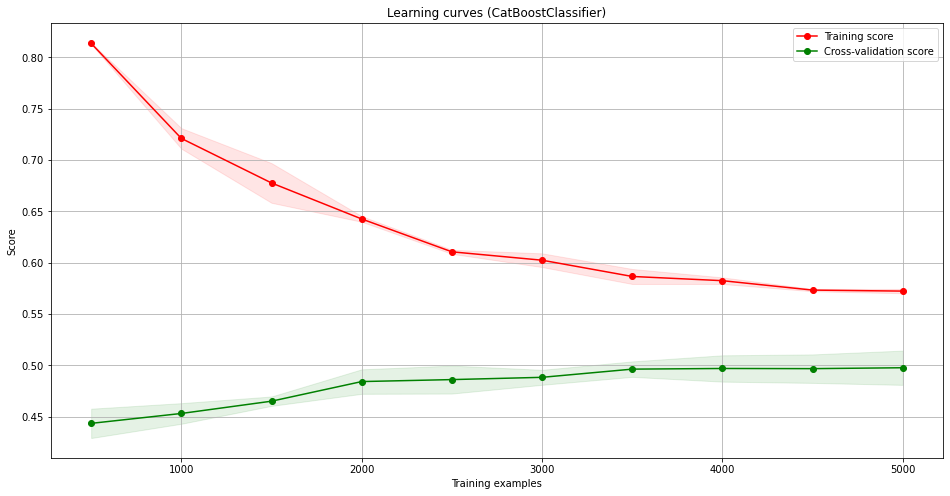

In [978]:
show_learning_curve_plot(model_catb, X[features], y)

Исходя из этого графика, лучшая обучающая выборка как раз на значении **5 000**. Оставим без изменений.

In [981]:
MODEL_FILE_PATH = './Models/model_3.pkl'

In [1164]:
X_train, X_valid, y_train, y_valid = train_test_split(X[features], y, test_size=0.333, stratify=y, random_state=42)

In [1184]:
model_final = catb.CatBoostClassifier(**frozen_params,
                                    iterations=70,
                                    max_depth=2,
                                    reg_lambda=0.1
                                    )
model_final.fit(X_train, y_train)
evaluate_preds(model_final, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.53      0.65      3593
           1       0.39      0.75      0.51      1409

    accuracy                           0.59      5002
   macro avg       0.61      0.64      0.58      5002
weighted avg       0.71      0.59      0.61      5002

TEST

              precision    recall  f1-score   support

           0       0.85      0.54      0.66      1794
           1       0.39      0.75      0.52       704

    accuracy                           0.60      2498
   macro avg       0.62      0.65      0.59      2498
weighted avg       0.72      0.60      0.62      2498

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               975  819
1               173  531


In [1185]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_final, file)

In [1186]:
target_predict = pd.DataFrame(model_final.predict(df_test[features]), columns=['Credit Default'])
target_predict.head()

,Credit Default
0,0
1,1
2,0
3,1
4,1


In [1187]:
target_predict.to_csv('catb9_predictions.csv', index_label='Id', encoding='utf-8', sep=',')